In [24]:
import tensorflow as tf
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [5]:
columns_to_drop = ['customerID']

df.drop(columns=columns_to_drop, inplace=True)

In [6]:
def replace_values(df, replace_dict):
    for keys, mapping in replace_dict.items():
        cols = [col for col in df.select_dtypes(include='object').columns if df[col].isin(keys).any()]
        df[cols] = df[cols].replace(mapping)
    return df

replace_map = {
    ('Yes', 'No'): {'Yes': 1, 'No': 0},
    ('Male', 'Female'): {'Male': 1, 'Female': 0}
}

df = replace_values(df, replace_map)


C:\Users\Yehor\AppData\Local\Temp\ipykernel_7404\2601653395.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols] = df[cols].replace(mapping)
C:\Users\Yehor\AppData\Local\Temp\ipykernel_7404\2601653395.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols] = df[cols].replace(mapping)


In [7]:
df.replace({
    'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
    'MultipleLines': {'No phone service': -1, 'No': 0, 'Yes': 1},
    'PaymentMethod': {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3},
    'InternetService': {'DSL': 1, 'Fiber optic': 2}
}, inplace=True)


C:\Users\Yehor\AppData\Local\Temp\ipykernel_7404\2279772442.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({


In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [9]:
df[['TotalCharges', 'MonthlyCharges']] = df[['TotalCharges', 'MonthlyCharges']] / 1000

In [10]:
df['tenure'] = df['tenure'] / 100

In [11]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,0.01,0,-1,1,0,1,0,0,0,0,0,1,0,0.02985,0.02985,0
1,1,0,0,0,0.34,1,0,1,1,0,1,0,0,0,1,0,1,0.05695,1.88950,0
2,1,0,0,0,0.02,1,0,1,1,1,0,0,0,0,0,1,1,0.05385,0.10815,1
3,1,0,0,0,0.45,0,-1,1,1,0,1,1,0,0,1,0,2,0.04230,1.84075,0
4,0,0,0,0,0.02,1,0,2,0,0,0,0,0,0,0,1,0,0.07070,0.15165,1


In [12]:
import json

mappings = {
    'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
    'MultipleLines': {'No phone service': -1, 'No': 0, 'Yes': 1},
    'PaymentMethod': {
        'Electronic check': 0,
        'Mailed check': 1,
        'Bank transfer (automatic)': 2,
        'Credit card (automatic)': 3
    },
    'InternetService': {'DSL': 1, 'Fiber optic': 2, 0: 0},
    'YesNoColumns': {'No': 0, 'Yes': 1}
}

scaling = {
    'TotalCharges': 1000,
    'MonthlyCharges': 1000,
    'tenure': 100
}

all_settings = {
    'mappings': mappings,
    'scaling': scaling
}

with open('preprocessing_config.json', 'w') as f:
    json.dump(all_settings, f, indent=4)

In [13]:
X = df.drop('Churn', axis=1).values  # features
y = df['Churn'].values  # labels

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

cat_features = [df.columns.get_loc(col) for col in categorical_cols if col in df.columns]



In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Припустимо, X — numpy-масив, y — ціль
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

num_cols_idx = [17, 18]  # заміни на правильні індекси числових колонок

scaler = StandardScaler()
X_train[:, num_cols_idx] = scaler.fit_transform(X_train[:, num_cols_idx])
X_valid[:, num_cols_idx] = scaler.transform(X_valid[:, num_cols_idx])


# Тренування моделі CatBoost
model = CatBoostClassifier(verbose=100, random_seed=42)
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_valid, y_valid), early_stopping_rounds=50)


Learning rate set to 0.048569
0:	learn: 0.6668562	test: 0.6666642	best: 0.6666642 (0)	total: 20.3ms	remaining: 20.2s
100:	learn: 0.3914092	test: 0.4151954	best: 0.4151603 (96)	total: 2s	remaining: 17.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4142518158
bestIteration = 130

Shrink model to first 131 iterations.


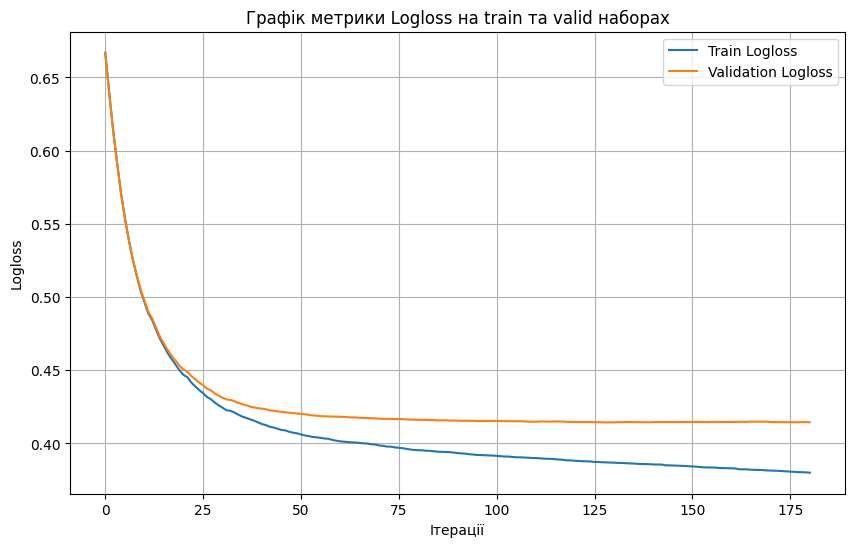

In [50]:
import matplotlib.pyplot as plt

# Після навчання моделі (model.fit(...))

evals_result = model.get_evals_result()

# Припустимо, метрика за замовчуванням — 'Logloss' для класифікації
train_metric = evals_result['learn']['Logloss']
valid_metric = evals_result['validation']['Logloss']

plt.figure(figsize=(10,6))
plt.plot(train_metric, label='Train Logloss')
plt.plot(valid_metric, label='Validation Logloss')
plt.xlabel('Ітерації')
plt.ylabel('Logloss')
plt.title('Графік метрики Logloss на train та valid наборах')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

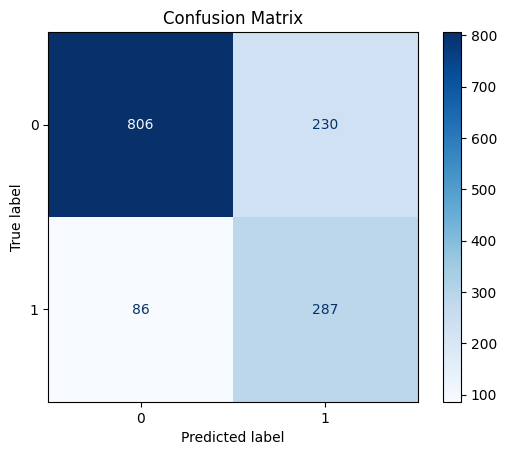

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_test - справжні мітки
# y_pred - передбачені мітки

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


ValueError: 2